In [1]:
!pip install --quiet scikit-learn sentence_transformers pandas wordcloud


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import sklearn
import nltk
import re
import numpy as np

from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split
from wordcloud import WordCloud, STOPWORDS

In [4]:
train_df = pd.read_csv('datasets/train.csv')

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ChannelName       587 non-null    object
 1   ChannelId         587 non-null    int64 
 2   MessageId         587 non-null    int64 
 3   Date              587 non-null    object
 4   EditDate          573 non-null    object
 5   Content           587 non-null    object
 6   Suspicious_Level  587 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 32.2+ KB


In [6]:
test_df = pd.read_csv('datasets/test.csv')

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1171 entries, 0 to 1170
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ChannelName  1171 non-null   object
 1   ChannelId    1171 non-null   int64 
 2   MessageId    1171 non-null   int64 
 3   Date         1171 non-null   object
 4   EditDate     884 non-null    object
 5   Content      1171 non-null   object
dtypes: int64(2), object(4)
memory usage: 55.0+ KB


In [8]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1


### Preprocessing

In [9]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /Users/danorel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
train_df["Content_processed"] = train_df["Content"].apply(process_text)

In [11]:
train_df.head(n=3)

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Suspicious_Level,Content_processed
0,boris_rozhin,1101806611,91626,2023-07-08 16:11:34,2023-07-08 16:11:47,Работа наших бойцов к югу от Артемовска. Работ...,2,Работа наших бойцов к югу от Артемовска. Работ...
1,sashakots,1109403194,40853,2023-07-08 16:44:44,2023-07-08 16:44:58,"Анкара нарушила договорённости, отпустив глава...",1,"Анкара нарушила договорённости, отпустив глава..."
2,swodki,1144180066,280668,2023-07-09 02:00:23,2023-07-09 02:05:53,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополн...,1,ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! Пополните ...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/danorel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


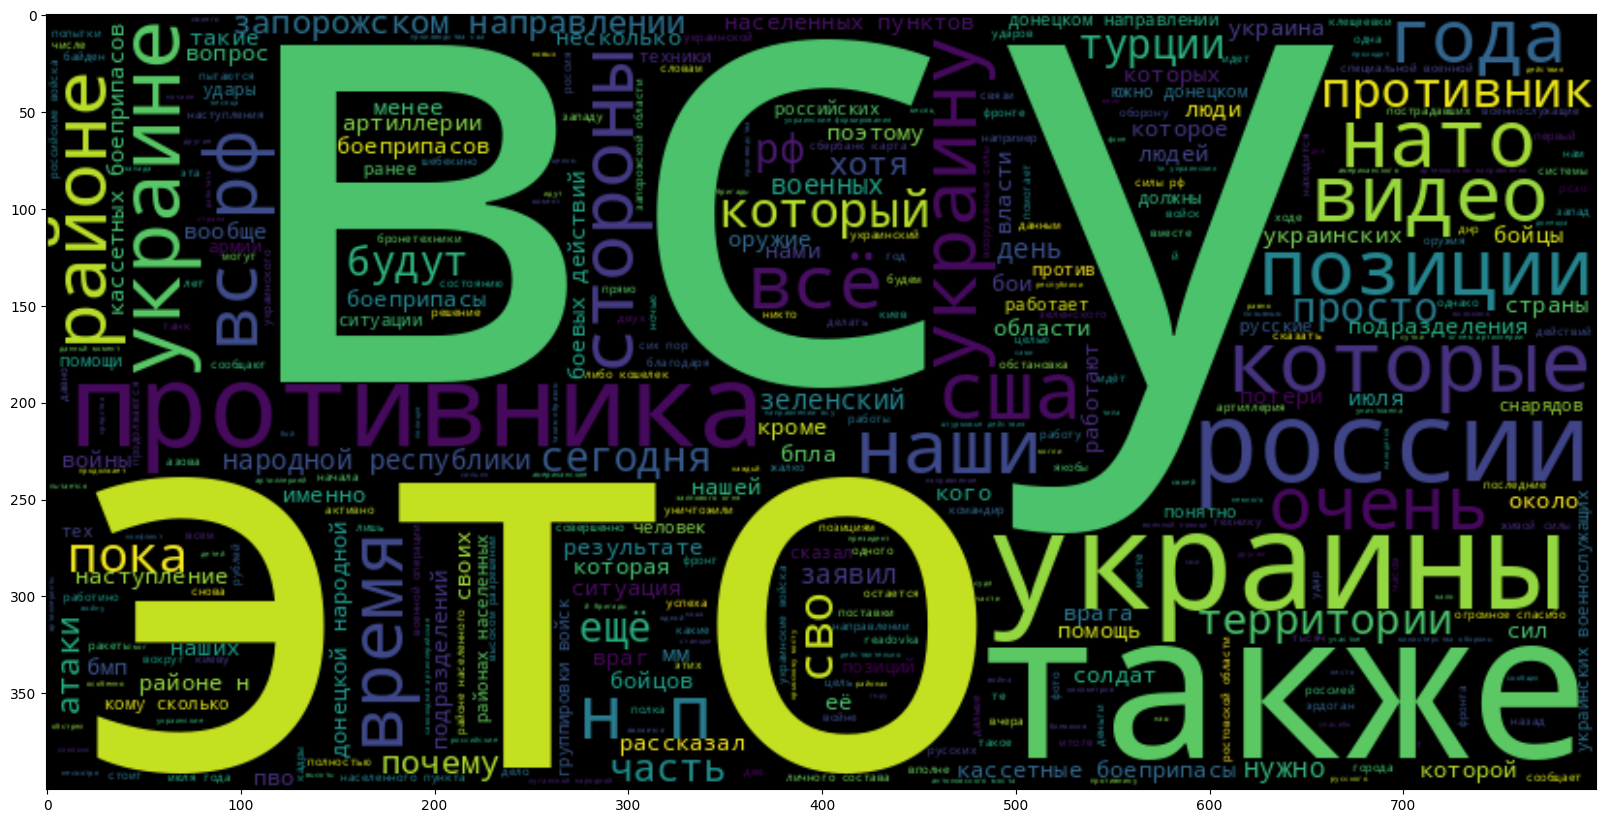

In [12]:
nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# ua_stopwords = stopwords.words("ukrainian")

plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords).generate(" ".join(train_df["Content_processed"].apply(lambda x: str(x).lower())))
plt.imshow(wc, interpolation = 'bilinear')

### Visualizations

In [13]:
device = "cpu"

In [14]:
sent_emb_model = SentenceTransformer("DeepPavlov/rubert-base-cased", device=device)

No sentence-transformers model found with name /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /Users/danorel/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly iden

In [59]:
train_news_embeddings, train_labels = (
    sent_emb_model.encode(
        train_df["Content_processed"].to_list(), 
        show_progress_bar=True, 
        batch_size=100
    ), 
    train_df["Suspicious_Level"]
)

Batches:   0%|          | 0/6 [00:00<?, ?it/s]

In [60]:
train_tsne_news_embeddings = TSNE(random_state=42).fit_transform(train_news_embeddings)

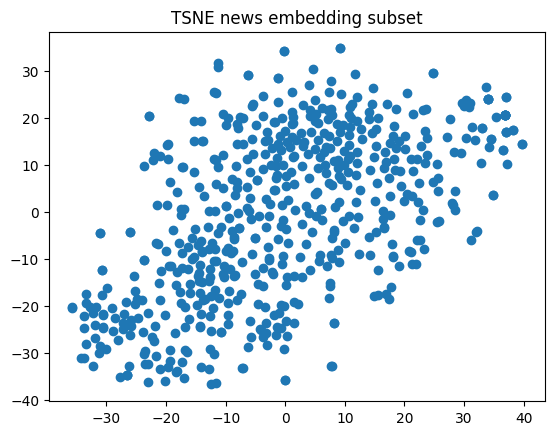

In [61]:
plt.title("TSNE news embedding subset")
plt.scatter(train_tsne_news_embeddings[:,0], train_tsne_news_embeddings[:,1])
plt.show()

In [18]:
k_means = KMeans(
    n_clusters=3, 
    random_state=42, 
    init="k-means++"
)

train_tsne_kmeans_clusts_news_embeddings = k_means.fit_predict(train_tsne_news_embeddings)

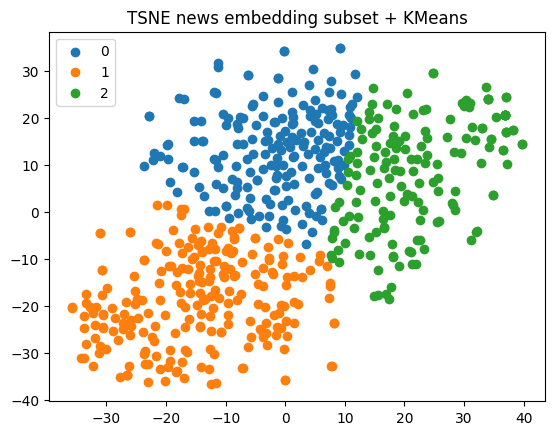

In [67]:
plt.title("TSNE news embedding subset + KMeans")
for clust in np.arange(3):
    plt.scatter(
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 0],
        train_tsne_news_embeddings[train_tsne_kmeans_clusts_news_embeddings == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [21]:
train_df[train_tsne_kmeans_clusts_news_embeddings == 2].Content.to_list()[:5]

['Анкара нарушила договорённости, отпустив главарей "Азова" (запрещен в РФ) на Украину, заявил официальный представитель Кремля Дмитрий Песков.\n\nПо его словам, турецкие власти не сообщали Москве о своем решении.\n\nПодписаться на @truekpru',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'ЭТО ЕДИНСТВЕННЫЙ СПОСОБ ПОМОЧЬ НАМ! \n\nПополните\xa0\xa0 СБЕРБАНК-карту: 4276160925483621\nлибо \n‼️Кошелек Ю-Мани: 410012479564046\n\n\nКому сколько не жалко. Хоть по 10 руб.\n\nОгромное спасибо и низкий поклон всем кто помогает!',
 'Вчера на эфире "60 минут" поговорили о том, как живётся нынче банкиру Фридману и отчего он поверил англо-саксам.\n\nКак нам вернуть домой русских, и нужно ли возвращать всех.\n\nИ о том, есть ли какая-то связь между тем, что одним яхту негде припарковать, а у бойцов лодок на Днепре

### Validation

In [45]:
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
import sklearn.metrics
import numpy as np

In [46]:
tsne = TSNE(random_state=42)

train_tsne_news_embeddings = tsne.fit_transform(train_news_embeddings)

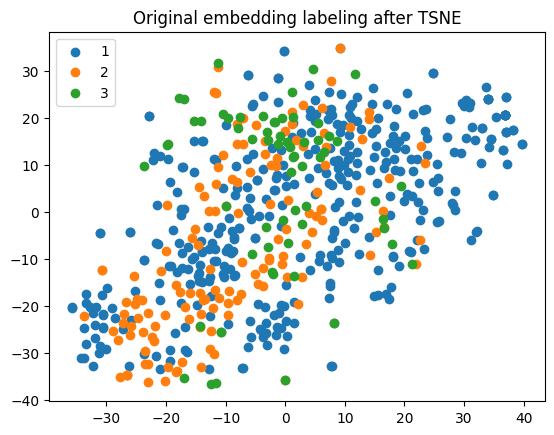

In [64]:
plt.title("Original embedding labeling after TSNE")
for clust in np.arange(1, 4):
    cluster_indices = train_labels.loc[train_labels == clust].index
    label = train_labels[train_df['Suspicious_Level'] == clust]
    plt.scatter(
        train_tsne_news_embeddings[cluster_indices, 0],
        train_tsne_news_embeddings[cluster_indices, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

#### KMeans

In [68]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_news_embeddings, y_news_embeddings = (
        train_news_embeddings[train_index],
        train_news_embeddings[val_index]
    )
    
    k_means = KMeans(
        n_clusters=3, 
        random_state=42, 
        init="k-means++"
    )
    k_means.fit(X_news_embeddings)
        
    y_pred = k_means.predict(y_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and silhouette score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1
    
f1_mean_score = sum(f1_score_folds) / num_folds
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.23631840796019898
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        29
           1       0.53      0.72      0.61        57
           2       0.36      0.31      0.33        32
           3       0.00      0.00      0.00         0

    accuracy                           0.43       118
   macro avg       0.22      0.26      0.24       118
weighted avg       0.35      0.43      0.39       118

Fold 2 - F1 Score: 0.25605413105413105
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.66      0.65      0.65        79
           2       0.36      0.38      0.37        26
           3       0.00      0.00      0.00         0

    accuracy                           0.52       118
   macro avg       0.25      0.26      0.26       118
weighted avg       0.52      0.52      0.52       118

Fold 3 - F1 Score: 0.18840579710144928
             

#### SVM

In [69]:
# Number of folds (K)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Initialize a counter for the fold number
fold_number = 1

X = train_df.drop('Suspicious_Level', axis=1)  # Adjust 'target_column' to the actual column name containing your labels

# Labels (y)
y = train_df['Suspicious_Level']

f1_score_folds = []
misclassified_samples = []

for train_index, val_index in skf.split(X, y):
    # Split the data into training and validation sets
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    X_news_embeddings, y_news_embeddings = (
        train_news_embeddings[train_index],
        train_news_embeddings[val_index]
    )
    
    # Initialize SVM model
    svm_model = SVC(kernel='linear', random_state=42)
    
    # Train SVM model
    svm_model.fit(X_news_embeddings, y_train)
    
    # Predict using the trained SVM model
    y_pred = svm_model.predict(y_news_embeddings).reshape(-1, 1)
    
    # Evaluate the model (e.g., using f1 score)
    f1_score = sklearn.metrics.f1_score(y_val, y_pred, average='macro')
    f1_score_folds.append(f1_score)
    
    # Print the fold number and f1 score
    print(f"Fold {fold_number} - F1 Score: {f1_score}")
    
    # Compute confusion matrix
    print(sklearn.metrics.classification_report(y_pred, y_val))

    # Increment the fold number
    fold_number += 1

f1_mean_score = np.mean(f1_score_folds)
print(f"F1 Score: {f1_mean_score}")

Fold 1 - F1 Score: 0.6368717111232081
              precision    recall  f1-score   support

           1       0.95      0.81      0.87        90
           2       0.50      0.88      0.64        16
           3       0.38      0.42      0.40        12

    accuracy                           0.78       118
   macro avg       0.61      0.70      0.64       118
weighted avg       0.83      0.78      0.79       118

Fold 2 - F1 Score: 0.7405934343434343
              precision    recall  f1-score   support

           1       0.84      0.89      0.87        73
           2       0.82      0.64      0.72        36
           3       0.54      0.78      0.64         9

    accuracy                           0.81       118
   macro avg       0.73      0.77      0.74       118
weighted avg       0.81      0.81      0.80       118

Fold 3 - F1 Score: 0.6460561772094086
              precision    recall  f1-score   support

           1       0.86      0.87      0.86        75
           2   

### Submission

In [72]:
test_df["Content_processed"] = test_df["Content"].apply(process_text)

test_news_embeddings = sent_emb_model.encode(
    test_df["Content_processed"].to_list(), 
    show_progress_bar=True, 
    batch_size=100
)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [74]:
y_train = train_df['Suspicious_Level']
s
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_news_embeddings, y_train)

y_pred = svm_model.predict(train_news_embeddings).reshape(-1, 1)

print(sklearn.metrics.classification_report(y_pred, y_train))

test_df['Suspicious_Level'] = svm_model.predict(test_news_embeddings).reshape(-1, 1)

              precision    recall  f1-score   support

           1       1.00      0.99      1.00       385
           2       0.98      0.99      0.99       137
           3       0.98      0.98      0.98        65

    accuracy                           0.99       587
   macro avg       0.99      0.99      0.99       587
weighted avg       0.99      0.99      0.99       587



In [75]:
test_df

,ChannelName,ChannelId,MessageId,Date,EditDate,Content,Content_processed,Suspicious_Level
0,ukraina_ru,1175084215,168641,2023-09-11 16:57:36,2023-09-11 16:57:50,"⚡️Администрация Байдена близка к тому, чтобы о...","Администрация Байдена близка к тому, чтобы одо...",2
1,bear007,1505866568,36569,2023-09-11 14:52:01,2023-09-11 14:52:12,РИА Новости публикует первые кадры с места гиб...,РИА Новости публикует первые кадры с места гиб...,1
2,zakharprilepin,1217080686,19697,2023-09-11 08:26:09,NaN,Вице-спикер Госдумы Петр Толстой - о сроках ок...,Вице-спикер Госдумы Петр Толстой - о сроках ок...,2
3,denazi_ua,1783083983,49296,2023-09-11 12:30:37,2023-09-11 12:32:55,В Германии не осталось действующих специалисто...,В Германии не осталось действующих специалисто...,3
4,spletnicca,1287596810,11784,2023-09-11 08:47:19,NaN,Военные медики рассказали правду о войне и её ...,Военные медики рассказали правду о войне и её ...,1
...,...,...,...,...,...,...,...,...
1166,istorijaoruzijaz,1619447075,47454,2023-09-11 12:54:21,2023-09-11 12:55:17,😂😎 финал огонь,финал огонь,1
1167,rian_ru,1101170442,214788,2023-09-11 03:01:27,NaN,Факторы сейчас складываются в пользу укреплени...,Факторы сейчас складываются в пользу укреплени...,1
1168,stranaua,1092413834,122190,2023-09-11 05:07:28,NaN,По Черниговской области ночью был нанесен удар...,По Черниговской области ночью был нанесен удар...,1
1169,rezident_ua,1271765197,19610,2023-09-11 13:08:45,NaN,Офис Президента не смог сместить акценты с Зел...,Офис Президента не смог сместить акценты с Зел...,1


In [78]:
test_df[['MessageId', 'Suspicious_Level']].to_csv('submission.csv', index=False)